# Analysis of cortical network model

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from network import NeuralNetwork
from logger import logger
from utils import *

t0 = time.perf_counter()

## Input parameters

In [24]:
# Stimulus parameters
start = 250 # start time (ms)
dur = 150  # duration (ms)
Pref = 1e6  # pressure amplitude (Pa)
Pmax = 3e6  # maximum pressure amplitude (Pa)
Iref = pressure_to_intensity(Pref) / 1e4  # corresponding intensity (W/cm2)
Imax = pressure_to_intensity(Pmax) / 1e4  # corresponding intensity (W/cm2)
Isppa_range = sqrtspace(0, Imax, 15)  # range of intensities to sweep
Isppa_range_dense = sqrtspace(0, Imax, 30)  # dense range of intensities to sweep

# Simulation parameters
tstop = 700  # default simulation duration (ms)
nreps = 1  # number of repetitions per simulation (for sweep trends)

# Logging
paramsstr = {
    'stimulus': [
        f'start = {start} ms',
        f'duration = {dur} ms',
        f'P = {Pref * 1e-6:.1f} MPa <-> I = {Iref:.2f} W/cm2',
        f'range of intensities = {Isppa_range[0]:.2f} - {Isppa_range[-1]:.2f} W/cm2'],
    'simulation': [
        f'duration = {tstop} ms',
        f'number of repetitions (for sweeps) = {nreps}']
}
paramsstr = {k: '\n'.join([f'       - {x}' for x in v]) for k, v in paramsstr.items()}
paramsstr = '\n'.join([f'   - {k}:\n{v}' for k, v in paramsstr.items()]) 
logger.info('Input parameters:\n' + paramsstr)

 11/12/2023 15:29:30: Input parameters:
   - stimulus:
       - start = 250 ms
       - duration = 150 ms
       - P = 1.0 MPa <-> I = 30.91 W/cm2
       - range of intensities = 0.00 - 278.22 W/cm2
   - simulation:
       - duration = 700 ms
       - number of repetitions (for sweeps) = 1


## Network model

In [4]:
# Initialize 3-nodes model temperature-dependent components
nnodes = 3
model = NeuralNetwork(
    nnodes, 
    Q10_rates=3,
    Q10_gNa=1.40,
    Q10_gKd=4.75,
    gKT=0.58e-9 / (NeuralNetwork.Acell * NeuralNetwork.UM_TO_CM**2),  # S/cm2
    a=1e-4, 
    b=0.5
)

# Set stimulus
model.set_stim(Iref, start=start, dur=dur)

# Set simulation duration
model.tstop = tstop

 11/12/2023 14:49:45: NeuralNetwork(3): created 3 nodes
 11/12/2023 14:49:45: NeuralNetwork(3): connecting all node pairs
 11/12/2023 14:49:45: NeuralNetwork(3): setting Q10_rates = 3 on all nodes


 11/12/2023 14:49:45: NeuralNetwork(3): setting Q10_gNa = 1.4 on all nodes
 11/12/2023 14:49:45: NeuralNetwork(3): setting Q10_gKd = 4.75 on all nodes
 11/12/2023 14:49:45: NeuralNetwork(3): setting gKT = 4.898648648648648e-06 on all nodes
 11/12/2023 14:49:45: NeuralNetwork(3): setting a = 0.0001 on all nodes
 11/12/2023 14:49:45: NeuralNetwork(3): setting b = 0.5 on all nodes
 11/12/2023 14:49:45: NeuralNetwork(3): initialized
 11/12/2023 14:49:45: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 30.9 W/cm2
    - node 1: 30.9 W/cm2
    - node 2: 30.9 W/cm2


## Simulations

### Test simulation

 11/12/2023 14:49:47: NeuralNetwork(3): disabled currents: iNaKPump


 11/12/2023 14:49:47: NeuralNetwork(3): simulating for 700.00 ms
 11/12/2023 14:49:47: NeuralNetwork(3): extracting output results
 11/12/2023 14:49:47: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.4 °C
    - node 1: ΔT = 0.4 °C
    - node 2: ΔT = 0.4 °C
 11/12/2023 14:49:47: NeuralNetwork(3): number of spikes:
    - node 0: n = 1 spikes
    - node 1: n = 1 spikes
    - node 2: n = 1 spikes
 11/12/2023 14:49:47: NeuralNetwork(3): firing rate:
    - node 0: FR = N/A   FR
    - node 1: FR = N/A   FR
    - node 2: FR = N/A   FR
 11/12/2023 14:49:47: NeuralNetwork(3): plotting results


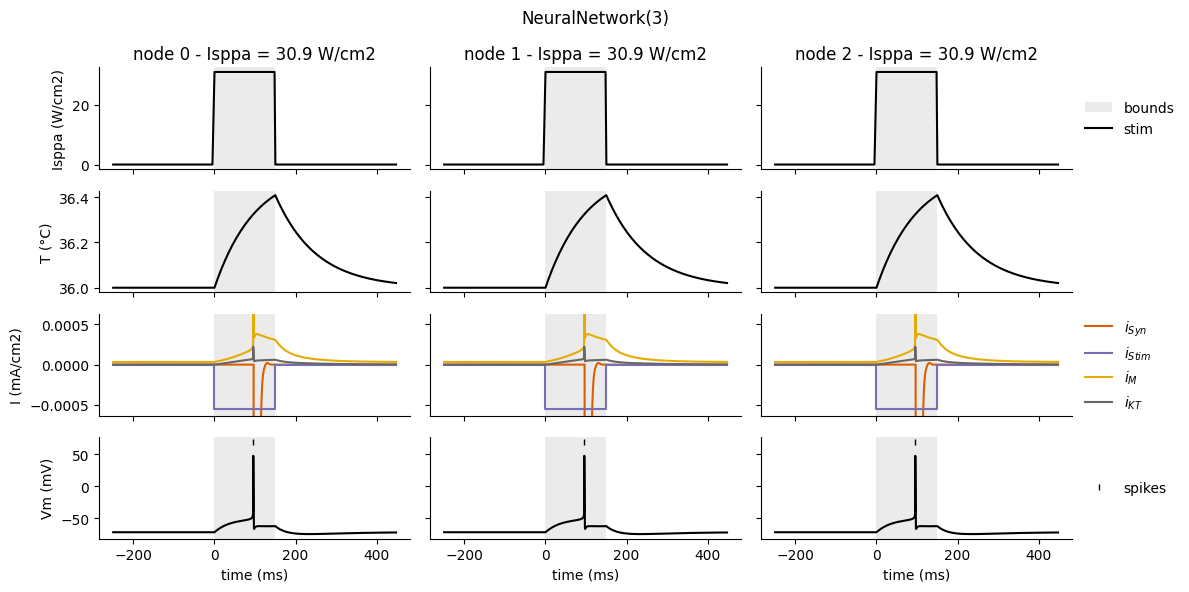

In [5]:
data = model.simulate()
fig = model.plot_results(
    data, 
    exclude=['conductances', 'iNa', 'iKd', 'iLeak'], 
    clip_currents=True)

## Explore combined impact of synaptic coupling and stimulus sensitivity on evoked activity in single-node vs multi-node stimulation

### Explore with stimulus sensitivity linearly dependent on intensity (exponent set to 1)

 11/12/2023 14:50:14: NeuralNetwork(3): setting b = 1 on all nodes
 11/12/2023 14:50:14: NeuralNetwork(3): setting a = 4.9999999999999996e-06 on all nodes
 11/12/2023 14:50:15: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 14:50:15: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 61.21it/s]

 11/12/2023 14:50:15: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 56.61it/s]

 11/12/2023 14:50:15: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 14:50:15: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 61.75it/s]

 11/12/2023 14:50:15: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 57.93it/s]

 11/12/2023 14:50:16: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 14:50:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 61.36it/s]

 11/12/2023 14:50:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 49.07it/s]

 11/12/2023 14:50:16: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:50:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 61.51it/s]

 11/12/2023 14:50:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 41.80it/s]

 11/12/2023 14:50:17: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:50:17: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 53.92it/s]

 11/12/2023 14:50:17: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 30.88it/s]

 11/12/2023 14:50:18: NeuralNetwork(3): setting a = 9.999999999999999e-06 on all nodes
 11/12/2023 14:50:18: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 14:50:18: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 51.57it/s]


 11/12/2023 14:50:18: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 47.93it/s]

 11/12/2023 14:50:18: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 14:50:18: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 47.55it/s]

 11/12/2023 14:50:19: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 43.05it/s]

 11/12/2023 14:50:19: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 14:50:19: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 45.95it/s]

 11/12/2023 14:50:19: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 33.15it/s]

 11/12/2023 14:50:20: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:50:20: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 41.90it/s]

 11/12/2023 14:50:20: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 24.44it/s]

 11/12/2023 14:50:21: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:50:21: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 31.24it/s]

 11/12/2023 14:50:21: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 20.88it/s]

 11/12/2023 14:50:22: NeuralNetwork(3): setting a = 1.9999999999999998e-05 on all nodes
 11/12/2023 14:50:22: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 14:50:22: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 38.72it/s]

 11/12/2023 14:50:23: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 31.60it/s]

 11/12/2023 14:50:23: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 14:50:23: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 33.34it/s]

 11/12/2023 14:50:24: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 26.99it/s]

 11/12/2023 14:50:24: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 14:50:24: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 31.96it/s]

 11/12/2023 14:50:25: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 20.94it/s]

 11/12/2023 14:50:25: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:50:25: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 24.83it/s]

 11/12/2023 14:50:26: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 18.65it/s]

 11/12/2023 14:50:27: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:50:27: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 20.46it/s]

 11/12/2023 14:50:28: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 17.27it/s]

 11/12/2023 14:50:29: NeuralNetwork(3): setting a = 3.9999999999999996e-05 on all nodes
 11/12/2023 14:50:29: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 14:50:29: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 24.79it/s]

 11/12/2023 14:50:29: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 20.37it/s]

 11/12/2023 14:50:30: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 14:50:30: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 24.35it/s]

 11/12/2023 14:50:31: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 18.61it/s]

 11/12/2023 14:50:32: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 14:50:32: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 18.92it/s]

 11/12/2023 14:50:32: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 16.42it/s]


 11/12/2023 14:50:33: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:50:33: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 17.22it/s]

 11/12/2023 14:50:34: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 14.92it/s]

 11/12/2023 14:50:35: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:50:35: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 14.38it/s]

 11/12/2023 14:50:37: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 14.29it/s]

 11/12/2023 14:50:38: plotting Isppa dependencies...


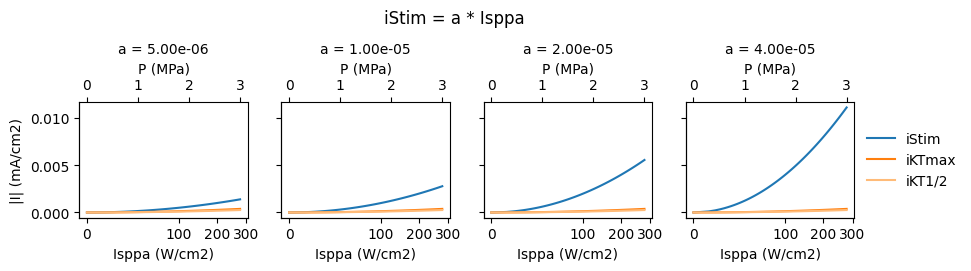

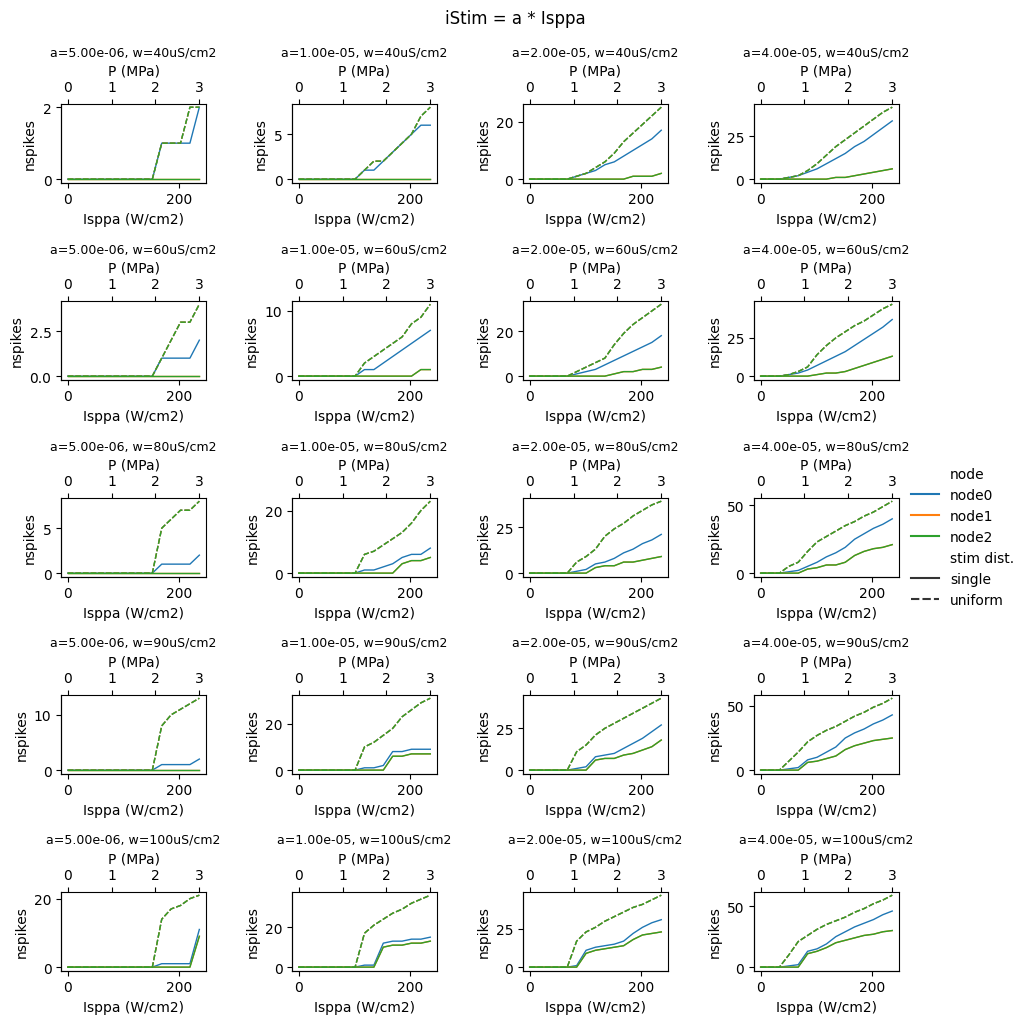

In [6]:
# Define vectors of synaptic weights
wrange = np.array([40, 60, 80, 90, 100]) * 1e-6  # S/cm2

# Define stimulus sensitivity parameter
model.set_mech_param(b=1)
arange = np.array([5, 10, 20, 40]) * 1e-6

# Explore 2D parameter space, and plot results
figs = model.explore2D(wrange, arange, Isppa_range, title='iStim = a * Isppa')

### Refined 2D search, within optimal parametric regime 

 11/12/2023 14:58:09: NeuralNetwork(3): setting a = 4.9999999999999996e-06 on all nodes
 11/12/2023 14:58:09: NeuralNetwork(3): setting all synaptic weights to 8.50e-05 S/cm2
 11/12/2023 14:58:09: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 58.43it/s]

 11/12/2023 14:58:09: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 44.53it/s]

 11/12/2023 14:58:10: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:58:10: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 59.20it/s]

 11/12/2023 14:58:10: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 39.38it/s]

 11/12/2023 14:58:10: NeuralNetwork(3): setting all synaptic weights to 9.50e-05 S/cm2
 11/12/2023 14:58:10: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 54.54it/s]

 11/12/2023 14:58:11: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 39.33it/s]

 11/12/2023 14:58:11: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:58:11: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 55.19it/s]

 11/12/2023 14:58:11: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 36.70it/s]

 11/12/2023 14:58:12: NeuralNetwork(3): setting a = 8.3e-06 on all nodes
 11/12/2023 14:58:12: NeuralNetwork(3): setting all synaptic weights to 8.50e-05 S/cm2
 11/12/2023 14:58:12: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 45.42it/s]

 11/12/2023 14:58:12: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 35.54it/s]

 11/12/2023 14:58:13: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:58:13: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 29.68it/s]

 11/12/2023 14:58:13: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 30.39it/s]

 11/12/2023 14:58:14: NeuralNetwork(3): setting all synaptic weights to 9.50e-05 S/cm2
 11/12/2023 14:58:14: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 37.48it/s]

 11/12/2023 14:58:14: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 27.69it/s]

 11/12/2023 14:58:15: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:58:15: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 33.05it/s]

 11/12/2023 14:58:15: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 21.37it/s]

 11/12/2023 14:58:16: NeuralNetwork(3): setting a = 1.1699999999999998e-05 on all nodes
 11/12/2023 14:58:16: NeuralNetwork(3): setting all synaptic weights to 8.50e-05 S/cm2
 11/12/2023 14:58:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 38.79it/s]

 11/12/2023 14:58:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 26.21it/s]

 11/12/2023 14:58:17: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:58:17: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 36.57it/s]

 11/12/2023 14:58:17: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 23.96it/s]

 11/12/2023 14:58:18: NeuralNetwork(3): setting all synaptic weights to 9.50e-05 S/cm2
 11/12/2023 14:58:18: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 32.41it/s]

 11/12/2023 14:58:19: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 19.19it/s]


 11/12/2023 14:58:19: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:58:19: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 26.86it/s]

 11/12/2023 14:58:20: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 20.61it/s]


 11/12/2023 14:58:21: NeuralNetwork(3): setting a = 1.4999999999999999e-05 on all nodes
 11/12/2023 14:58:21: NeuralNetwork(3): setting all synaptic weights to 8.50e-05 S/cm2
 11/12/2023 14:58:21: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 27.08it/s]

 11/12/2023 14:58:21: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 23.29it/s]

 11/12/2023 14:58:22: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:58:22: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 29.90it/s]


 11/12/2023 14:58:23: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 18.21it/s]

 11/12/2023 14:58:23: NeuralNetwork(3): setting all synaptic weights to 9.50e-05 S/cm2
 11/12/2023 14:58:23: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 28.27it/s]

 11/12/2023 14:58:24: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 20.45it/s]


 11/12/2023 14:58:25: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:58:25: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 20.05it/s]

 11/12/2023 14:58:26: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 19.33it/s]

 11/12/2023 14:58:26: plotting Isppa dependencies...


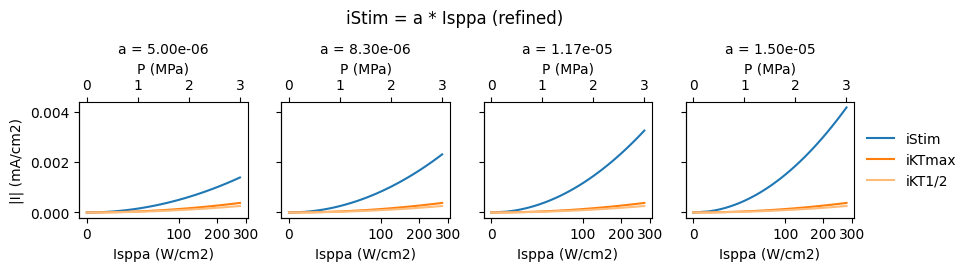

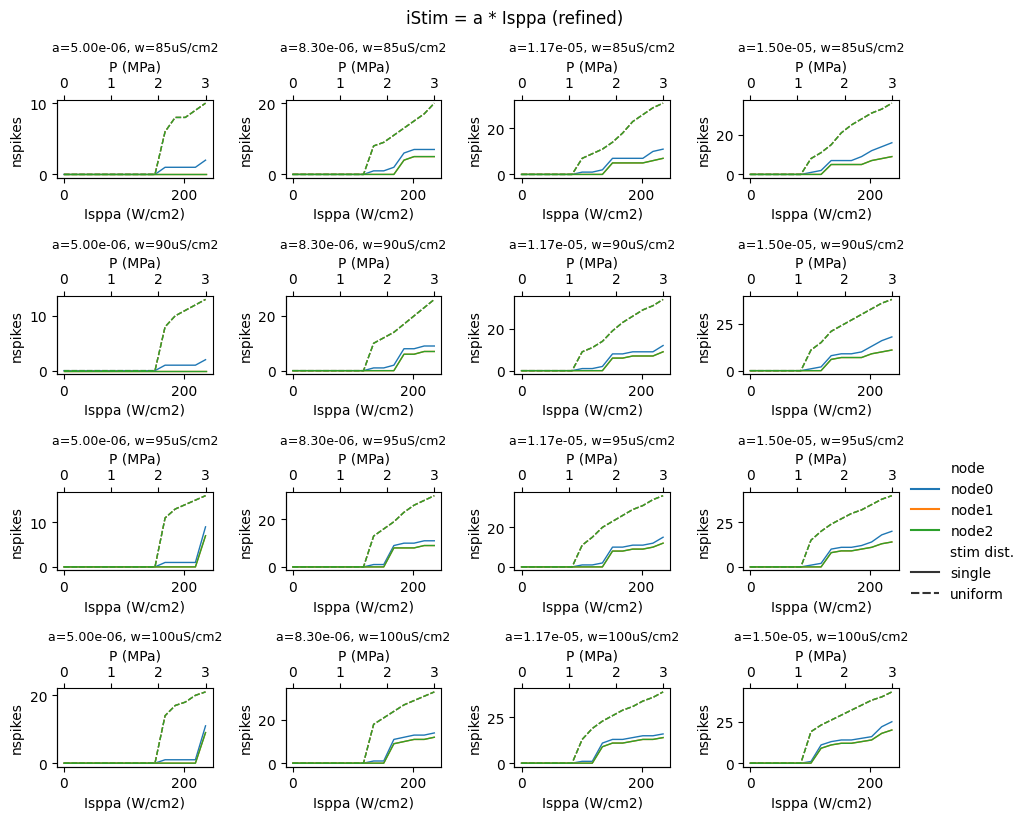

In [11]:
wrange_refined = np.linspace(85, 100, 4).round(1) * 1e-6  # S/cm2
arange_refined = np.linspace(5, 15, 4).round(1) * 1e-6
figs = model.explore2D(wrange_refined, arange_refined, Isppa_range, title='iStim = a * Isppa (refined)')

### Explore with stimulus sensitivity linearly dependent on pressure (exponent set to 0.5)

 11/12/2023 14:59:34: NeuralNetwork(3): setting b = 0.5 on all nodes
 11/12/2023 14:59:34: NeuralNetwork(3): setting a = 5e-05 on all nodes
 11/12/2023 14:59:34: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 14:59:34: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 58.39it/s]

 11/12/2023 14:59:35: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 62.76it/s]

 11/12/2023 14:59:35: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 14:59:35: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 66.88it/s]

 11/12/2023 14:59:35: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 64.31it/s]

 11/12/2023 14:59:35: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 14:59:35: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 65.88it/s]

 11/12/2023 14:59:36: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 66.11it/s]

 11/12/2023 14:59:36: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:59:36: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 60.12it/s]

 11/12/2023 14:59:36: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 64.63it/s]

 11/12/2023 14:59:36: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:59:36: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 63.22it/s]

 11/12/2023 14:59:37: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 64.52it/s]

 11/12/2023 14:59:37: NeuralNetwork(3): setting a = 0.0001 on all nodes
 11/12/2023 14:59:37: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 14:59:37: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 54.66it/s]

 11/12/2023 14:59:37: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 51.34it/s]

 11/12/2023 14:59:38: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 14:59:38: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 54.72it/s]

 11/12/2023 14:59:38: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 47.46it/s]


 11/12/2023 14:59:38: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 14:59:38: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 45.57it/s]

 11/12/2023 14:59:39: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 35.72it/s]

 11/12/2023 14:59:39: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:59:39: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 41.41it/s]

 11/12/2023 14:59:39: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 29.17it/s]

 11/12/2023 14:59:40: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:59:40: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 22.41it/s]

 11/12/2023 14:59:41: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 21.35it/s]

 11/12/2023 14:59:41: NeuralNetwork(3): setting a = 0.0002 on all nodes
 11/12/2023 14:59:41: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 14:59:41: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 39.51it/s]

 11/12/2023 14:59:42: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 33.66it/s]

 11/12/2023 14:59:42: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 14:59:42: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 37.07it/s]

 11/12/2023 14:59:43: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 27.66it/s]

 11/12/2023 14:59:43: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 14:59:43: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 31.43it/s]

 11/12/2023 14:59:44: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 17.04it/s]

 11/12/2023 14:59:45: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:59:45: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 27.47it/s]


 11/12/2023 14:59:45: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 17.65it/s]

 11/12/2023 14:59:46: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:59:46: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 16.85it/s]


 11/12/2023 14:59:47: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 16.06it/s]


 11/12/2023 14:59:48: NeuralNetwork(3): setting a = 0.0004 on all nodes
 11/12/2023 14:59:48: NeuralNetwork(3): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 14:59:48: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 25.88it/s]

 11/12/2023 14:59:49: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 16.96it/s]

 11/12/2023 14:59:50: NeuralNetwork(3): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 14:59:50: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 24.08it/s]

 11/12/2023 14:59:50: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 17.20it/s]

 11/12/2023 14:59:51: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 14:59:51: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 16.37it/s]

 11/12/2023 14:59:52: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 14.85it/s]


 11/12/2023 14:59:53: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 14:59:53: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 14.72it/s]


 11/12/2023 14:59:54: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 12.25it/s]

 11/12/2023 14:59:56: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 14:59:56: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 11.79it/s]

 11/12/2023 14:59:57: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 13.08it/s]

 11/12/2023 14:59:58: plotting Isppa dependencies...


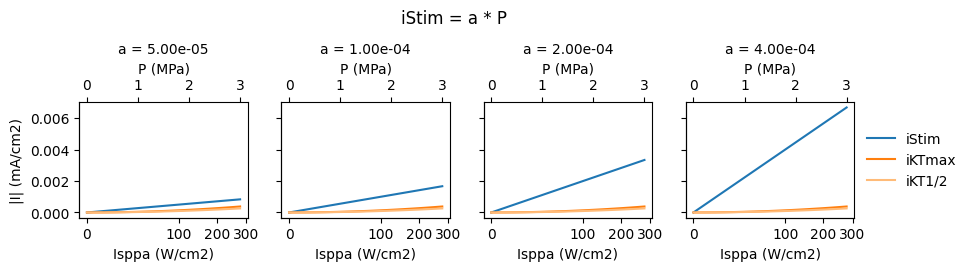

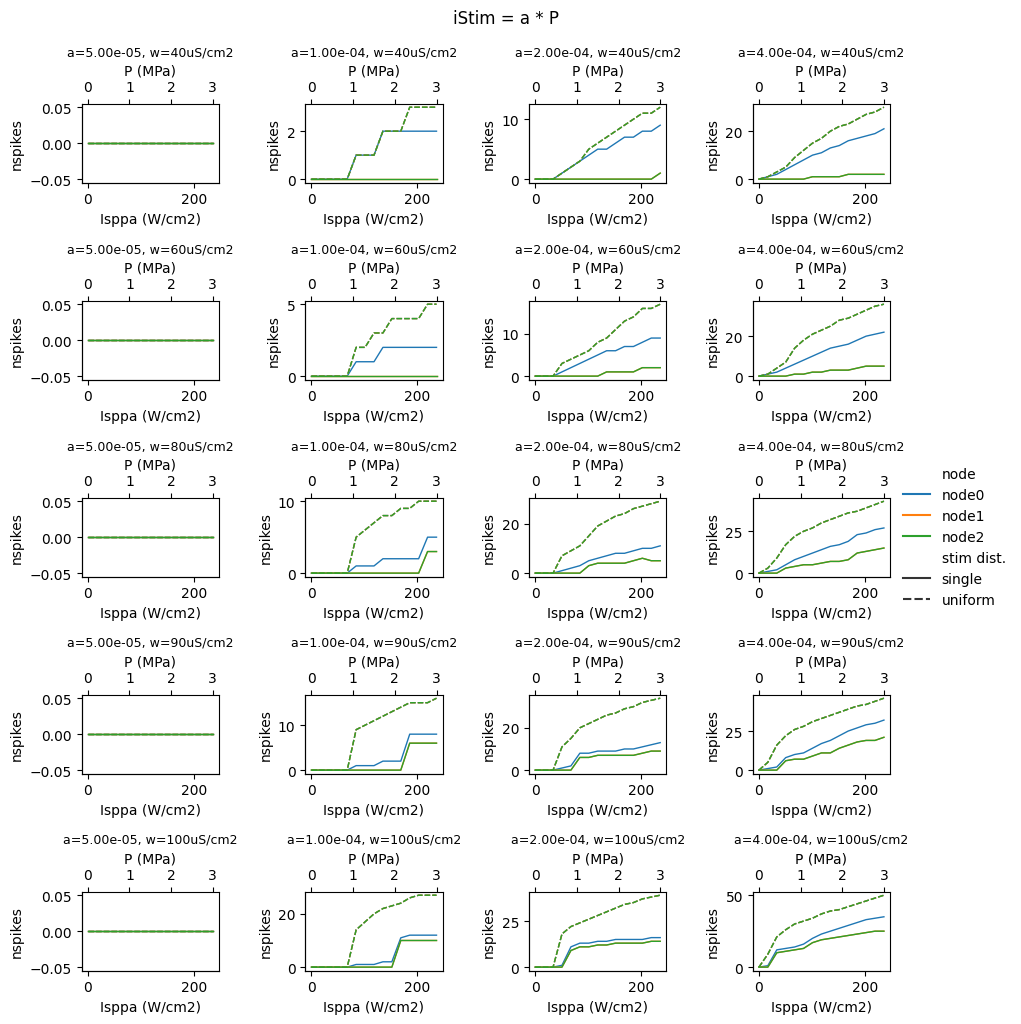

In [12]:
# Define stimulus sensitivity parameter
model.set_mech_param(b=0.5)
arange = np.array([5, 10, 20, 40]) * 1e-5

# Explore 2D parameter space, and plot results
figs = model.explore2D(wrange, arange, Isppa_range, title='iStim = a * P')

### Refined 2D search, within optimal parametric regime

 11/12/2023 15:06:03: NeuralNetwork(3): setting a = 7.500000000000001e-05 on all nodes
 11/12/2023 15:06:03: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 15:06:03: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 54.43it/s]

 11/12/2023 15:06:03: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 17.54it/s]

 11/12/2023 15:06:04: NeuralNetwork(3): setting all synaptic weights to 8.50e-05 S/cm2
 11/12/2023 15:06:04: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 55.90it/s]

 11/12/2023 15:06:04: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 34.27it/s]

 11/12/2023 15:06:05: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 15:06:05: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 55.26it/s]

 11/12/2023 15:06:05: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 33.84it/s]

 11/12/2023 15:06:05: NeuralNetwork(3): setting all synaptic weights to 9.50e-05 S/cm2
 11/12/2023 15:06:05: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 55.66it/s]

 11/12/2023 15:06:06: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 30.22it/s]

 11/12/2023 15:06:06: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 15:06:06: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 48.26it/s]

 11/12/2023 15:06:07: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 26.81it/s]

 11/12/2023 15:06:07: NeuralNetwork(3): setting a = 0.0001 on all nodes
 11/12/2023 15:06:07: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 15:06:07: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 47.72it/s]

 11/12/2023 15:06:08: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 34.04it/s]

 11/12/2023 15:06:08: NeuralNetwork(3): setting all synaptic weights to 8.50e-05 S/cm2
 11/12/2023 15:06:08: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 43.67it/s]

 11/12/2023 15:06:08: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 32.70it/s]

 11/12/2023 15:06:09: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 15:06:09: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 40.98it/s]

 11/12/2023 15:06:09: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 27.61it/s]

 11/12/2023 15:06:10: NeuralNetwork(3): setting all synaptic weights to 9.50e-05 S/cm2
 11/12/2023 15:06:10: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 35.81it/s]

 11/12/2023 15:06:10: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 24.40it/s]

 11/12/2023 15:06:11: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 15:06:11: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 31.80it/s]

 11/12/2023 15:06:11: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 20.71it/s]

 11/12/2023 15:06:12: NeuralNetwork(3): setting a = 0.000125 on all nodes
 11/12/2023 15:06:12: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 15:06:12: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 41.79it/s]

 11/12/2023 15:06:13: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 28.25it/s]

 11/12/2023 15:06:13: NeuralNetwork(3): setting all synaptic weights to 8.50e-05 S/cm2
 11/12/2023 15:06:13: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 38.05it/s]

 11/12/2023 15:06:14: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 26.56it/s]

 11/12/2023 15:06:14: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 15:06:14: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 34.37it/s]

 11/12/2023 15:06:15: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 16.03it/s]

 11/12/2023 15:06:16: NeuralNetwork(3): setting all synaptic weights to 9.50e-05 S/cm2
 11/12/2023 15:06:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 30.85it/s]

 11/12/2023 15:06:16: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 19.91it/s]

 11/12/2023 15:06:17: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 15:06:17: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 26.00it/s]


 11/12/2023 15:06:18: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 18.87it/s]


 11/12/2023 15:06:18: NeuralNetwork(3): setting a = 0.00015000000000000001 on all nodes
 11/12/2023 15:06:19: NeuralNetwork(3): setting all synaptic weights to 8.00e-05 S/cm2
 11/12/2023 15:06:19: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 38.46it/s]

 11/12/2023 15:06:19: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 26.11it/s]

 11/12/2023 15:06:20: NeuralNetwork(3): setting all synaptic weights to 8.50e-05 S/cm2
 11/12/2023 15:06:20: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 32.55it/s]

 11/12/2023 15:06:20: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 14.83it/s]

 11/12/2023 15:06:21: NeuralNetwork(3): setting all synaptic weights to 9.00e-05 S/cm2
 11/12/2023 15:06:21: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 29.59it/s]

 11/12/2023 15:06:22: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 18.53it/s]

 11/12/2023 15:06:22: NeuralNetwork(3): setting all synaptic weights to 9.50e-05 S/cm2
 11/12/2023 15:06:22: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 26.11it/s]

 11/12/2023 15:06:23: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 17.66it/s]

 11/12/2023 15:06:24: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 15:06:24: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:00<00:00, 22.17it/s]


 11/12/2023 15:06:25: NeuralNetwork(3): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:00<00:00, 17.33it/s]

 11/12/2023 15:06:26: plotting Isppa dependencies...


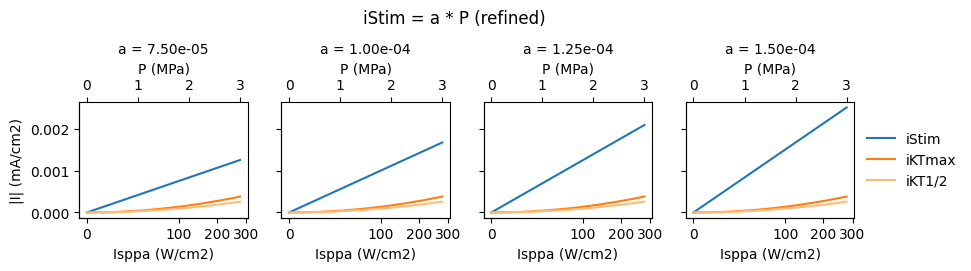

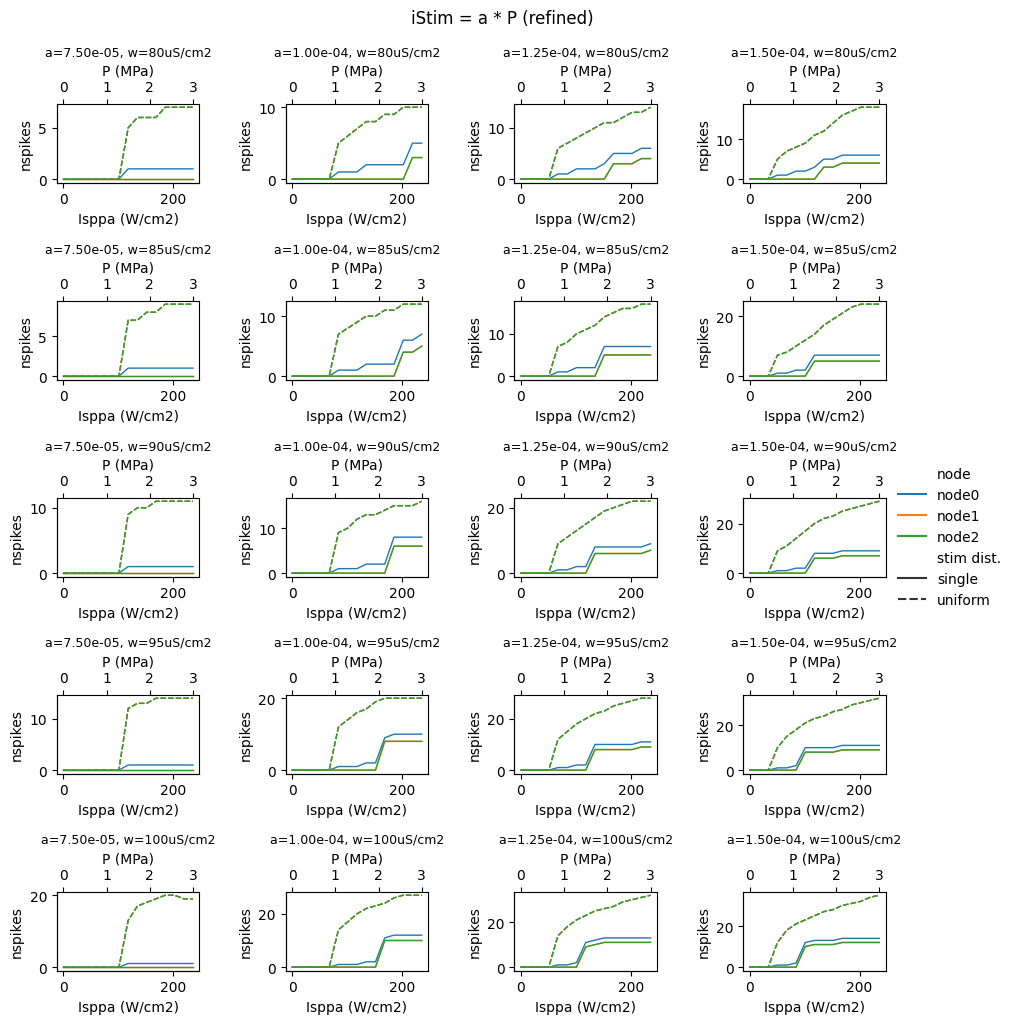

In [17]:
wrange_refined = np.linspace(80, 100, 5).round(1) * 1e-6  # S/cm2
arange_refined = np.linspace(7.5, 15, 4).round(1) * 1e-5
figs = model.explore2D(wrange_refined, arange_refined, Isppa_range, title='iStim = a * P (refined)')

### Detailed Isppa dependencies and sub-threshold simulations for optimal parameter combinations

 11/12/2023 15:09:15: NeuralNetwork(3): setting all synaptic weights to 1.00e-04 S/cm2
 11/12/2023 15:09:15: NeuralNetwork(3): setting a = 0.0001 on all nodes
 11/12/2023 15:09:15: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [00:00<00:00, 31.55it/s]

 11/12/2023 15:09:16: NeuralNetwork(3): running simulation sweep across 30 stimulus intensities



100%|██████████| 30/30 [00:01<00:00, 21.53it/s]


 11/12/2023 15:09:17: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 26.8 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
 11/12/2023 15:09:17: NeuralNetwork(3): disabled currents: iNaKPump
 11/12/2023 15:09:17: NeuralNetwork(3): simulating for 700.00 ms
 11/12/2023 15:09:17: NeuralNetwork(3): extracting output results
 11/12/2023 15:09:17: NeuralNetwork(3): max temperature increase:
    - node 0: ΔT = 0.4 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
 11/12/2023 15:09:18: NeuralNetwork(3): number of spikes:
    - node 0: n = 0 spikes
    - node 1: n = 0 spikes
    - node 2: n = 0 spikes
 11/12/2023 15:09:18: NeuralNetwork(3): firing rate:
    - node 0: FR = N/A   FR
    - node 1: FR = N/A   FR
    - node 2: FR = N/A   FR
 11/12/2023 15:09:18: NeuralNetwork(3): plotting results
 11/12/2023 15:09:19: NeuralNetwork(3): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 26.8 W/cm2
    - node 1: 26.8 W/cm2
    -

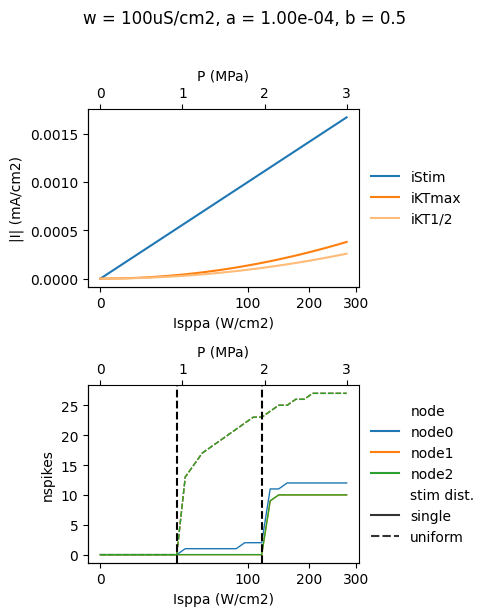

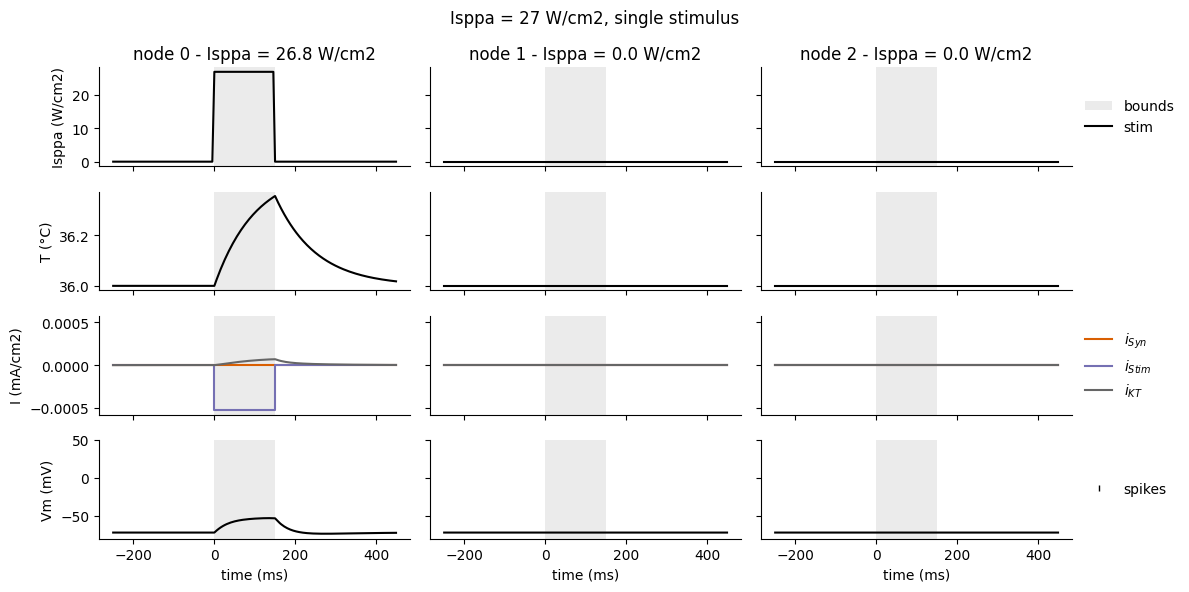

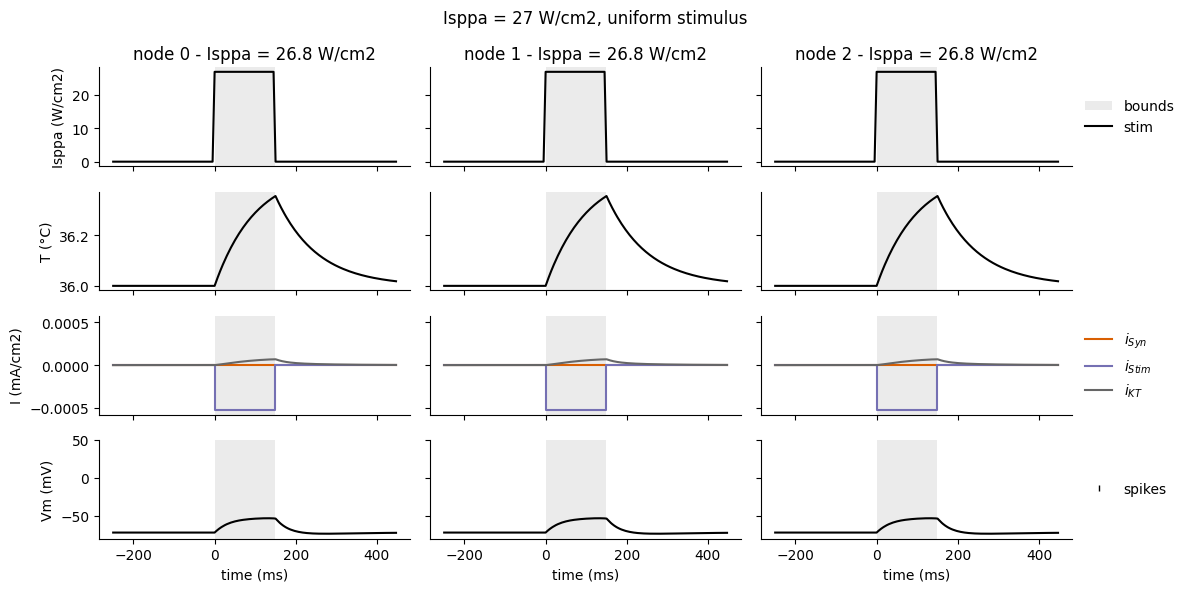

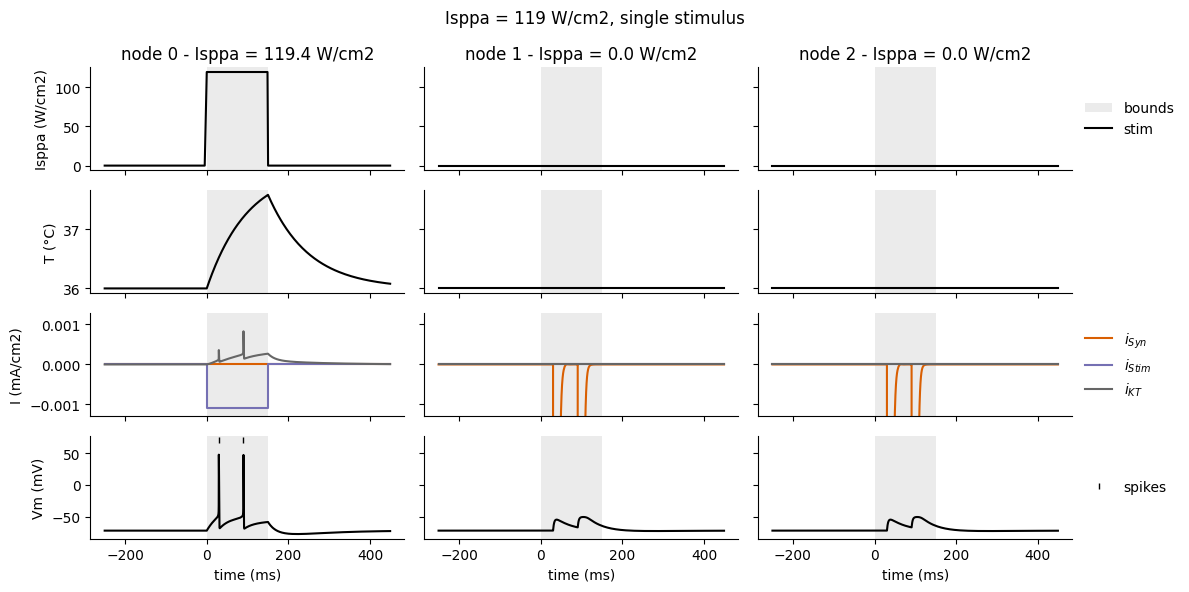

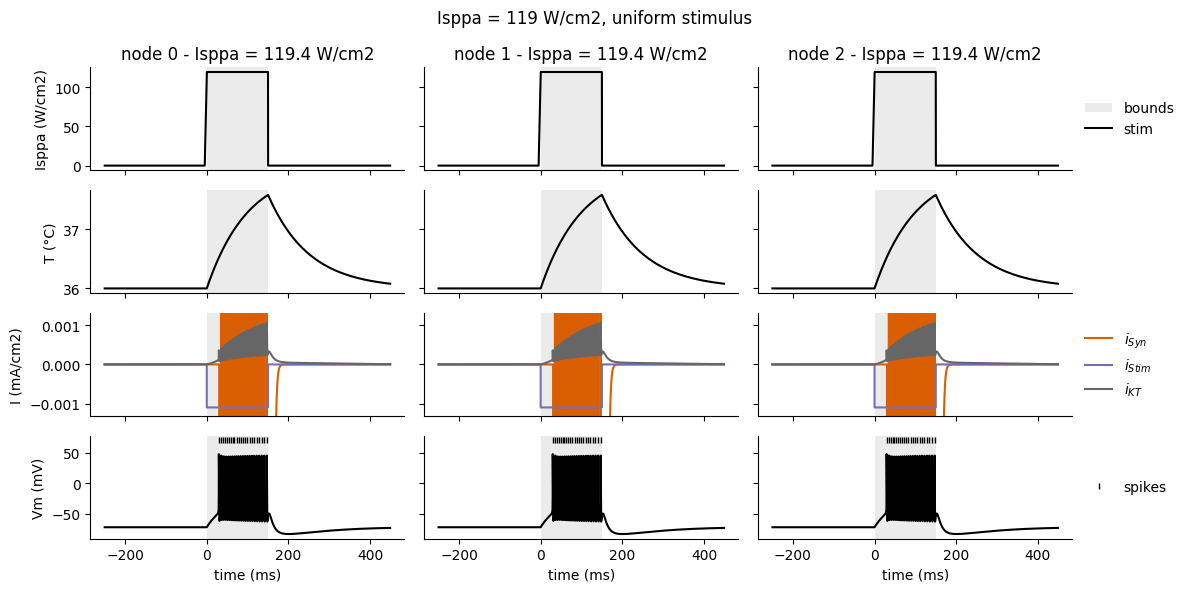

In [19]:
# Define synaptic weight and stimulus sensitivity parameters
model.set_synaptic_weight(100e-6)
model.set_mech_param(
    a=1e-4, 
    b=0.5
)

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

# Pot E/I imbalance across Isppa range
model.plot_EI_imbalance(Imax, ax=axes[0], legend=True, xscale='sqrt')

# Plot comparative spike count across Isppa range
metric = model.run_comparative_sweep(Isppa_range_dense, 'nspikes')
model.plot_sweep_results(metric, ax=axes[1], legend=True, marker=None, xscale='sqrt')

# Adjust figure title and layout
fig.suptitle(f'w = {model.get_synaptic_weight() * 1e6:.0f}uS/cm2, a = {model.a:.2e}, b = {model.b}', y=1.02, fontsize=12)
fig.tight_layout()

# Find just sub-threshold Isppa values for each configuration
Ithrs = np.sort(model.find_threshold(metric, value=10).unique())

# Run comparative simulations and plot results with each sub-threshold Isppa values
for Isppa in Ithrs:
    fig.axes[1].axvline(Isppa, color='k', linestyle='--')
    for kind, xvec in model.get_stimdists().items():
        model.set_stim(Isppa * xvec)
        data = model.simulate()
        model.plot_results(
            data,
            exclude=['conductances', 'iNa', 'iKd', 'iLeak', 'iM'],
            clip_currents=True, 
            title=f'Isppa = {Isppa:.0f} W/cm2, {kind} stimulus')

## Expanded 5 nodes model

In [20]:
# Create copy of model with 5 nodes
model5 = model.copy(nnodes=5)

# Define stimulus distributions
stimdists = {
    '1 node': model5.get_stimdist_vector(kind=1),
    '3 nodes': model5.get_stimdist_vector(kind=3),
    '5 nodes': model5.get_stimdist_vector(kind=5)
}

 11/12/2023 15:11:32: NeuralNetwork(5): created 5 nodes
 11/12/2023 15:11:32: NeuralNetwork(5): connecting all node pairs
 11/12/2023 15:11:32: NeuralNetwork(5): setting Q10_rates = 3 on all nodes
 11/12/2023 15:11:32: NeuralNetwork(5): setting Q10_gNa = 1.4 on all nodes
 11/12/2023 15:11:32: NeuralNetwork(5): setting Q10_gKd = 4.75 on all nodes
 11/12/2023 15:11:32: NeuralNetwork(5): setting gKT = 4.898648648648648e-06 on all nodes
 11/12/2023 15:11:32: NeuralNetwork(5): setting a = 0.0001 on all nodes
 11/12/2023 15:11:32: NeuralNetwork(5): setting b = 0.5 on all nodes
 11/12/2023 15:11:32: NeuralNetwork(5): initialized
 11/12/2023 15:11:32: NeuralNetwork(5): setting all synaptic weights to 1.00e-04 S/cm2


### Initial parametric search

 11/12/2023 15:11:41: NeuralNetwork(5): setting a = 5e-05 on all nodes
 11/12/2023 15:11:41: NeuralNetwork(5): setting all synaptic weights to 2.00e-05 S/cm2
 11/12/2023 15:11:41: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 10.62it/s]

 11/12/2023 15:11:42: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  7.83it/s]

 11/12/2023 15:11:44: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 10.93it/s]

 11/12/2023 15:11:46: NeuralNetwork(5): setting all synaptic weights to 3.00e-05 S/cm2
 11/12/2023 15:11:46: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.87it/s]

 11/12/2023 15:11:48: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 10.95it/s]

 11/12/2023 15:11:49: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.66it/s]


 11/12/2023 15:11:51: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:11:51: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 11.24it/s]

 11/12/2023 15:11:52: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


 11/12/2023 15:11:54: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 11.07it/s]

 11/12/2023 15:11:55: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:11:55: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.21it/s]

 11/12/2023 15:11:57: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


 11/12/2023 15:11:59: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.02it/s]

 11/12/2023 15:12:01: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:12:01: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 10.92it/s]

 11/12/2023 15:12:02: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.61it/s]

 11/12/2023 15:12:04: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 10.36it/s]


 11/12/2023 15:12:05: NeuralNetwork(5): setting a = 0.0001 on all nodes
 11/12/2023 15:12:05: NeuralNetwork(5): setting all synaptic weights to 2.00e-05 S/cm2
 11/12/2023 15:12:05: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.15it/s]

 11/12/2023 15:12:07: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 10.03it/s]

 11/12/2023 15:12:09: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  7.05it/s]

 11/12/2023 15:12:11: NeuralNetwork(5): setting all synaptic weights to 3.00e-05 S/cm2
 11/12/2023 15:12:11: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 10.96it/s]


 11/12/2023 15:12:13: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.57it/s]


 11/12/2023 15:12:15: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  9.15it/s]

 11/12/2023 15:12:16: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:12:16: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.64it/s]

 11/12/2023 15:12:18: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


 11/12/2023 15:12:20: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.80it/s]

 11/12/2023 15:12:22: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:12:22: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.09it/s]

 11/12/2023 15:12:24: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


 11/12/2023 15:12:25: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.55it/s]


 11/12/2023 15:12:27: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:12:27: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 11.28it/s]

 11/12/2023 15:12:29: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  7.19it/s]


 11/12/2023 15:12:31: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  7.09it/s]


 11/12/2023 15:12:33: NeuralNetwork(5): setting a = 0.0002 on all nodes
 11/12/2023 15:12:33: NeuralNetwork(5): setting all synaptic weights to 2.00e-05 S/cm2
 11/12/2023 15:12:33: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.63it/s]

 11/12/2023 15:12:35: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


 11/12/2023 15:12:37: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.64it/s]

 11/12/2023 15:12:39: NeuralNetwork(5): setting all synaptic weights to 3.00e-05 S/cm2
 11/12/2023 15:12:39: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00, 10.52it/s]

 11/12/2023 15:12:40: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  7.96it/s]

 11/12/2023 15:12:42: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  7.77it/s]


 11/12/2023 15:12:44: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:12:44: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 10.46it/s]

 11/12/2023 15:12:46: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  7.42it/s]


 11/12/2023 15:12:48: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


 11/12/2023 15:12:50: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:12:50: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.34it/s]

 11/12/2023 15:12:52: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.02it/s]


 11/12/2023 15:12:54: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


 11/12/2023 15:12:56: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:12:56: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.88it/s]


 11/12/2023 15:12:58: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.99it/s]


 11/12/2023 15:13:01: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.24it/s]


 11/12/2023 15:13:04: NeuralNetwork(5): setting a = 0.0004 on all nodes
 11/12/2023 15:13:04: NeuralNetwork(5): setting all synaptic weights to 2.00e-05 S/cm2
 11/12/2023 15:13:04: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.83it/s]


 11/12/2023 15:13:06: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.32it/s]


 11/12/2023 15:13:08: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.86it/s]


 11/12/2023 15:13:10: NeuralNetwork(5): setting all synaptic weights to 3.00e-05 S/cm2
 11/12/2023 15:13:10: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.76it/s]


 11/12/2023 15:13:12: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.59it/s]


 11/12/2023 15:13:14: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


 11/12/2023 15:13:17: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:13:17: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  7.43it/s]


 11/12/2023 15:13:19: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.98it/s]


 11/12/2023 15:13:21: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.94it/s]


 11/12/2023 15:13:24: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:13:24: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


 11/12/2023 15:13:26: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  4.93it/s]


 11/12/2023 15:13:29: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.85it/s]


 11/12/2023 15:13:32: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:13:32: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


 11/12/2023 15:13:34: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.19it/s]

 11/12/2023 15:13:37: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


 11/12/2023 15:13:40: plotting Isppa dependencies...


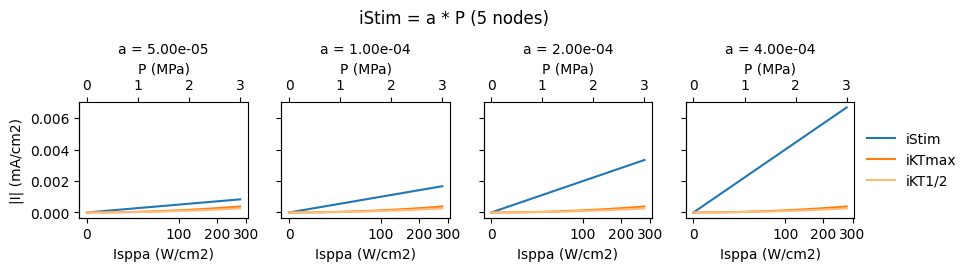

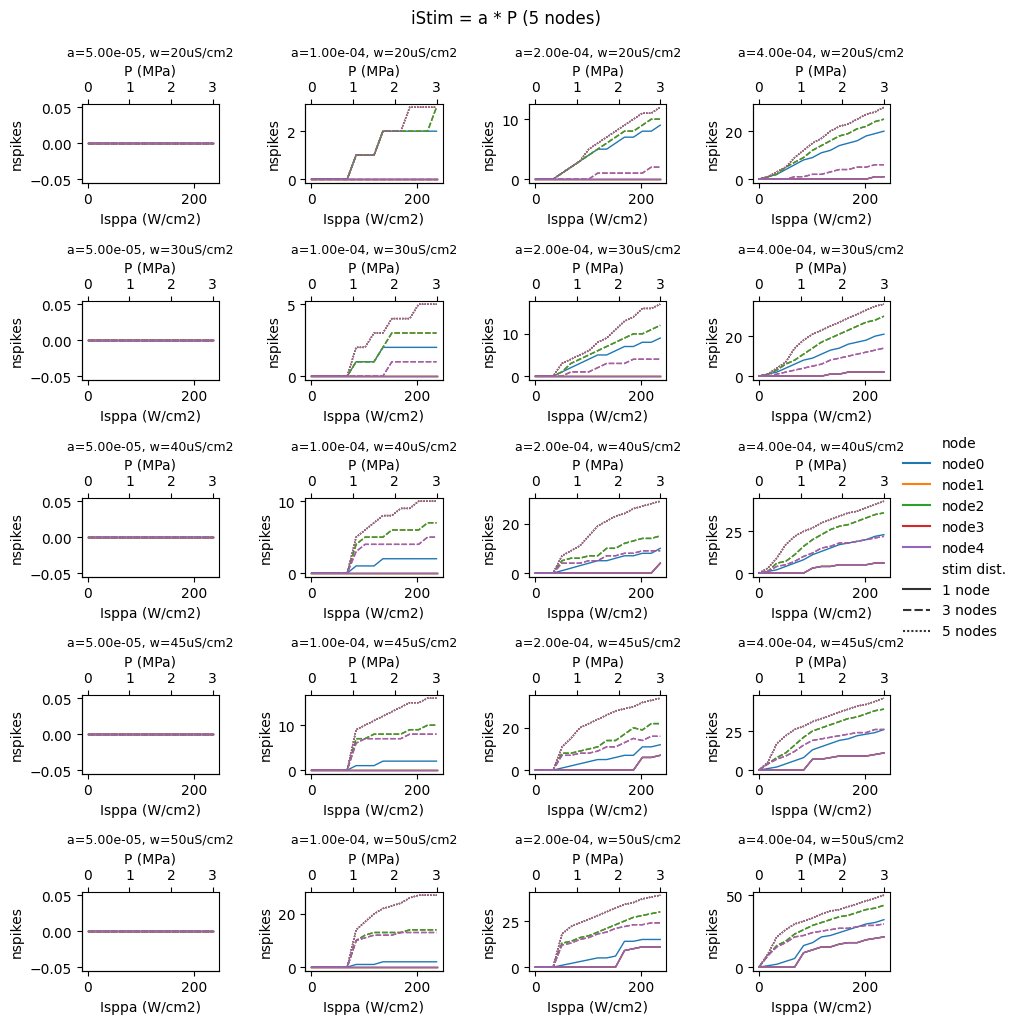

In [21]:
# Define vectors of synaptic weights
wrange = np.array([20, 30, 40, 45, 50]) * 1e-6  # S/cm2

# Explore 2D parameter space, and plot results
figs = model5.explore2D(wrange, arange, Isppa_range, title='iStim = a * P (5 nodes)', stimdists=stimdists)

### Refined 2D search

 11/12/2023 15:21:31: NeuralNetwork(5): setting a = 0.0001 on all nodes
 11/12/2023 15:21:31: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:21:31: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 10.66it/s]


 11/12/2023 15:21:33: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  7.33it/s]

 11/12/2023 15:21:35: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.67it/s]

 11/12/2023 15:21:36: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:21:36: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.26it/s]

 11/12/2023 15:21:38: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


 11/12/2023 15:21:40: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  7.18it/s]


 11/12/2023 15:21:42: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:21:42: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 10.64it/s]

 11/12/2023 15:21:44: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


 11/12/2023 15:21:46: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.36it/s]


 11/12/2023 15:21:49: NeuralNetwork(5): setting all synaptic weights to 5.50e-05 S/cm2
 11/12/2023 15:21:49: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 10.57it/s]

 11/12/2023 15:21:50: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  6.01it/s]


 11/12/2023 15:21:53: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.08it/s]


 11/12/2023 15:21:55: NeuralNetwork(5): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 15:21:55: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00, 11.09it/s]

 11/12/2023 15:21:57: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:03<00:00,  3.87it/s]


 11/12/2023 15:22:01: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.70it/s]


 11/12/2023 15:22:05: NeuralNetwork(5): setting a = 0.00015000000000000001 on all nodes
 11/12/2023 15:22:05: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:22:05: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.30it/s]


 11/12/2023 15:22:07: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  7.45it/s]


 11/12/2023 15:22:09: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.32it/s]


 11/12/2023 15:22:11: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:22:11: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.05it/s]

 11/12/2023 15:22:13: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.59it/s]


 11/12/2023 15:22:15: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


 11/12/2023 15:22:17: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:22:17: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.23it/s]

 11/12/2023 15:22:19: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  7.50it/s]


 11/12/2023 15:22:21: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.28it/s]


 11/12/2023 15:22:24: NeuralNetwork(5): setting all synaptic weights to 5.50e-05 S/cm2
 11/12/2023 15:22:24: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.84it/s]


 11/12/2023 15:22:26: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.53it/s]


 11/12/2023 15:22:29: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.78it/s]

 11/12/2023 15:22:31: NeuralNetwork(5): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 15:22:31: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  8.13it/s]


 11/12/2023 15:22:33: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.31it/s]


 11/12/2023 15:22:38: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.02it/s]


 11/12/2023 15:22:43: NeuralNetwork(5): setting a = 0.0002 on all nodes
 11/12/2023 15:22:43: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:22:43: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.00it/s]


 11/12/2023 15:22:45: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


 11/12/2023 15:22:47: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


 11/12/2023 15:22:50: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:22:50: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.71it/s]

 11/12/2023 15:22:52: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  7.94it/s]


 11/12/2023 15:22:54: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.25it/s]


 11/12/2023 15:22:56: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:22:56: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  7.48it/s]


 11/12/2023 15:22:58: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.79it/s]


 11/12/2023 15:23:01: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.99it/s]


 11/12/2023 15:23:03: NeuralNetwork(5): setting all synaptic weights to 5.50e-05 S/cm2
 11/12/2023 15:23:03: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.68it/s]


 11/12/2023 15:23:05: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.12it/s]


 11/12/2023 15:23:09: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.60it/s]


 11/12/2023 15:23:11: NeuralNetwork(5): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 15:23:11: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  4.64it/s]

 11/12/2023 15:23:15: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:04<00:00,  3.27it/s]


 11/12/2023 15:23:20: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


 11/12/2023 15:23:25: NeuralNetwork(5): setting a = 0.00025 on all nodes
 11/12/2023 15:23:25: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:23:25: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.59it/s]


 11/12/2023 15:23:27: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


 11/12/2023 15:23:29: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.25it/s]

 11/12/2023 15:23:32: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:23:32: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


 11/12/2023 15:23:34: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.04it/s]


 11/12/2023 15:23:36: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.02it/s]


 11/12/2023 15:23:39: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:23:39: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.97it/s]

 11/12/2023 15:23:41: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  5.39it/s]

 11/12/2023 15:23:44: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  6.76it/s]


 11/12/2023 15:23:46: NeuralNetwork(5): setting all synaptic weights to 5.50e-05 S/cm2
 11/12/2023 15:23:46: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.27it/s]


 11/12/2023 15:23:49: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  4.47it/s]

 11/12/2023 15:23:52: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  5.41it/s]

 11/12/2023 15:23:55: NeuralNetwork(5): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 15:23:55: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:03<00:00,  4.20it/s]

 11/12/2023 15:23:59: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:04<00:00,  3.07it/s]


 11/12/2023 15:24:04: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


 11/12/2023 15:24:10: NeuralNetwork(5): setting a = 0.00030000000000000003 on all nodes
 11/12/2023 15:24:10: NeuralNetwork(5): setting all synaptic weights to 4.00e-05 S/cm2
 11/12/2023 15:24:10: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:01<00:00,  7.52it/s]


 11/12/2023 15:24:12: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.11it/s]


 11/12/2023 15:24:14: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  7.26it/s]


 11/12/2023 15:24:17: NeuralNetwork(5): setting all synaptic weights to 4.50e-05 S/cm2
 11/12/2023 15:24:17: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.82it/s]


 11/12/2023 15:24:19: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.79it/s]


 11/12/2023 15:24:22: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  5.88it/s]


 11/12/2023 15:24:24: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:24:24: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:02<00:00,  6.74it/s]

 11/12/2023 15:24:27: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  5.28it/s]

 11/12/2023 15:24:30: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  5.58it/s]

 11/12/2023 15:24:32: NeuralNetwork(5): setting all synaptic weights to 5.50e-05 S/cm2
 11/12/2023 15:24:32: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  7.17it/s]


 11/12/2023 15:24:35: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:03<00:00,  4.36it/s]

 11/12/2023 15:24:38: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:02<00:00,  5.12it/s]

 11/12/2023 15:24:41: NeuralNetwork(5): setting all synaptic weights to 6.00e-05 S/cm2
 11/12/2023 15:24:41: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities



100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


 11/12/2023 15:24:45: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


 11/12/2023 15:24:51: NeuralNetwork(5): running simulation sweep across 15 stimulus intensities


100%|██████████| 15/15 [00:05<00:00,  2.83it/s]


 11/12/2023 15:24:56: plotting Isppa dependencies...


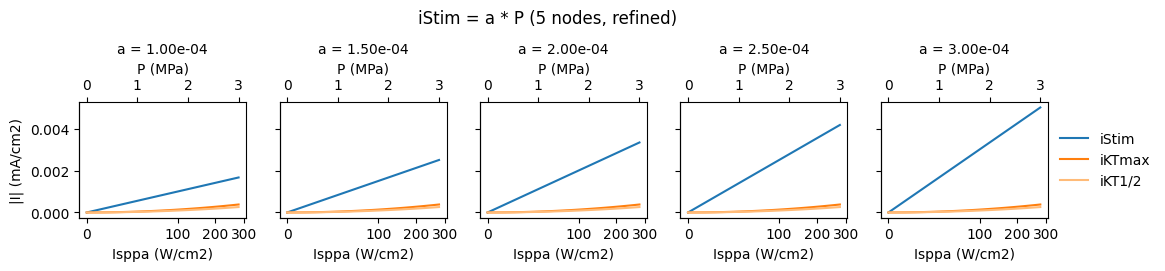

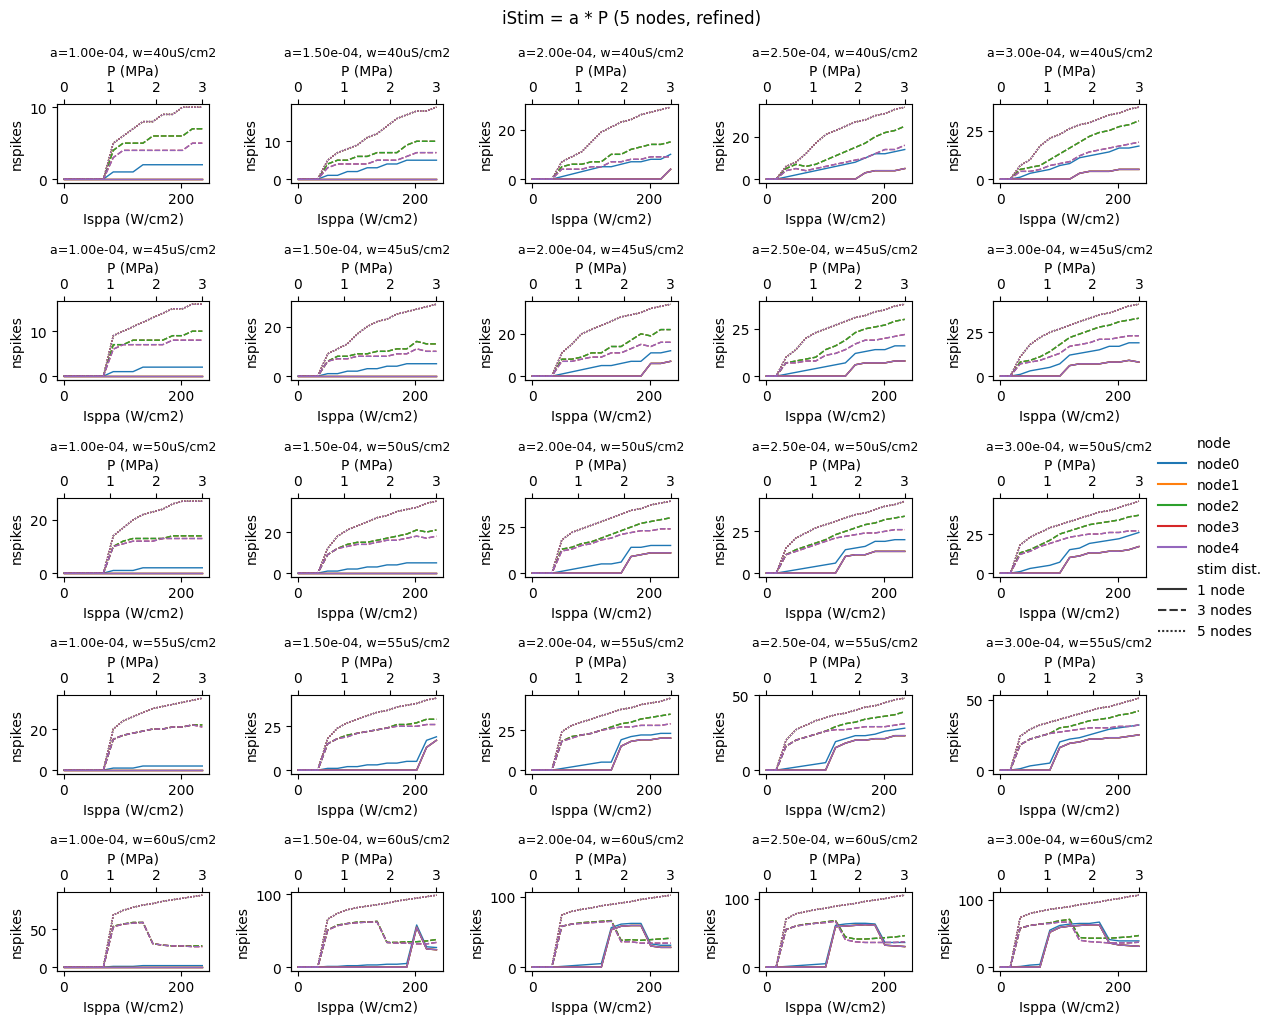

In [22]:
# Define vectors of synaptic weights
wrange_refined = np.linspace(40, 60, 5).round(1) * 1e-6  # S/cm2
arange_refined = np.linspace(1, 3, 5).round(1) * 1e-4

# Explore 2D parameter space, and plot results
figs = model5.explore2D(
    wrange_refined, arange_refined, Isppa_range, title='iStim = a * P (5 nodes, refined)', stimdists=stimdists)

### Detailed Isppa dependencies and sub-threshold simulations for optimal parameter combinations

 11/12/2023 15:27:25: NeuralNetwork(5): setting all synaptic weights to 5.00e-05 S/cm2
 11/12/2023 15:27:25: NeuralNetwork(5): setting a = 0.0002 on all nodes
 11/12/2023 15:27:25: NeuralNetwork(5): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [00:03<00:00,  7.57it/s]


 11/12/2023 15:27:29: NeuralNetwork(5): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [00:05<00:00,  5.43it/s]


 11/12/2023 15:27:35: NeuralNetwork(5): running simulation sweep across 30 stimulus intensities


100%|██████████| 30/30 [00:04<00:00,  6.43it/s]


 11/12/2023 15:27:41: NeuralNetwork(5): setting 150.00 ms stimulus with node-specific amplitudes:
    - node 0: 5.3 W/cm2
    - node 1: 0.0 W/cm2
    - node 2: 0.0 W/cm2
    - node 3: 0.0 W/cm2
    - node 4: 0.0 W/cm2
 11/12/2023 15:27:41: NeuralNetwork(5): disabled currents: iNaKPump
 11/12/2023 15:27:41: NeuralNetwork(5): simulating for 700.00 ms
 11/12/2023 15:27:41: NeuralNetwork(5): extracting output results
 11/12/2023 15:27:41: NeuralNetwork(5): max temperature increase:
    - node 0: ΔT = 0.1 °C
    - node 1: ΔT = 0.0 °C
    - node 2: ΔT = 0.0 °C
    - node 3: ΔT = 0.0 °C
    - node 4: ΔT = 0.0 °C
 11/12/2023 15:27:41: NeuralNetwork(5): number of spikes:
    - node 0: n = 0 spikes
    - node 1: n = 0 spikes
    - node 2: n = 0 spikes
    - node 3: n = 0 spikes
    - node 4: n = 0 spikes
 11/12/2023 15:27:41: NeuralNetwork(5): firing rate:
    - node 0: FR = N/A   FR
    - node 1: FR = N/A   FR
    - node 2: FR = N/A   FR
    - node 3: FR = N/A   FR
    - node 4: FR = N/A   FR
 

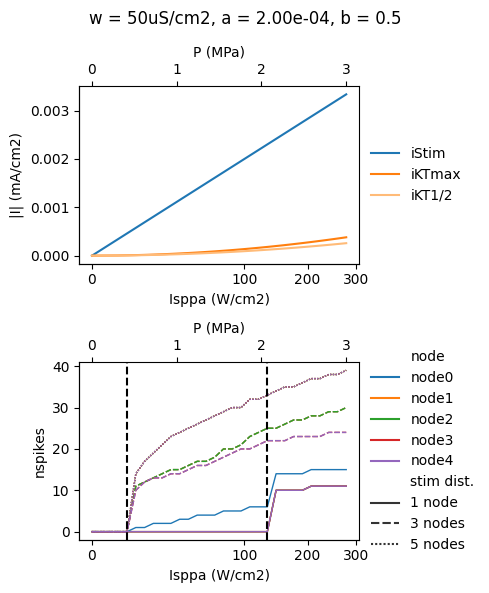

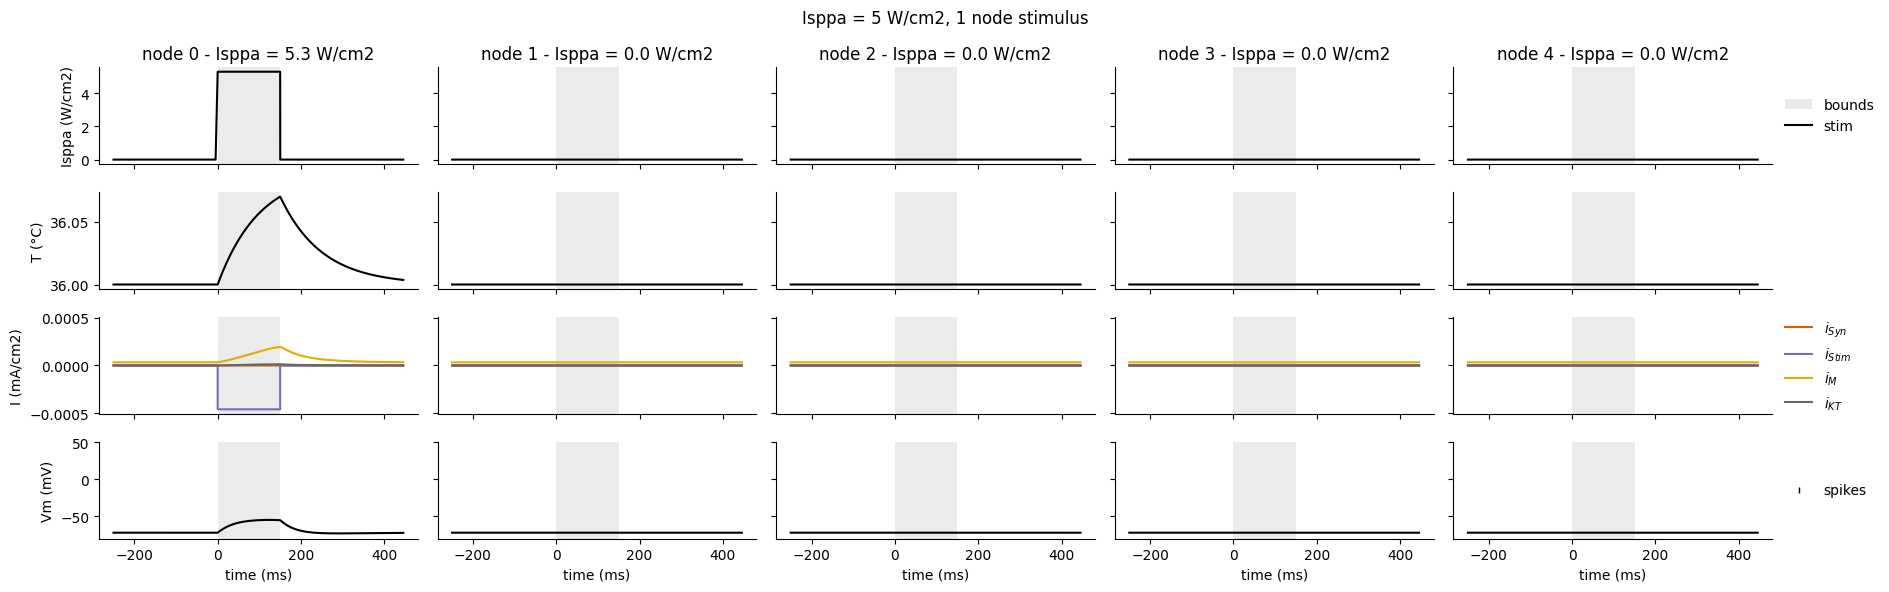

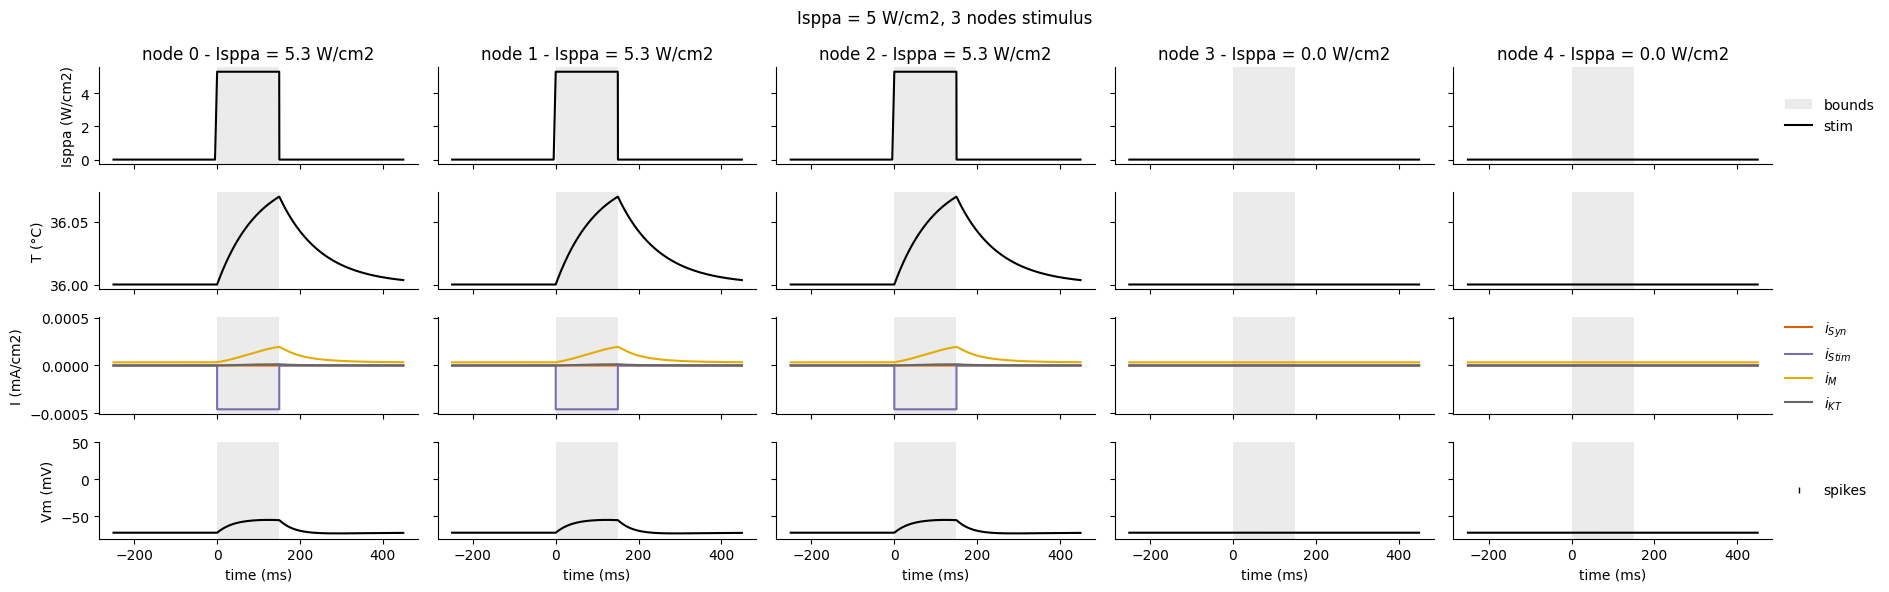

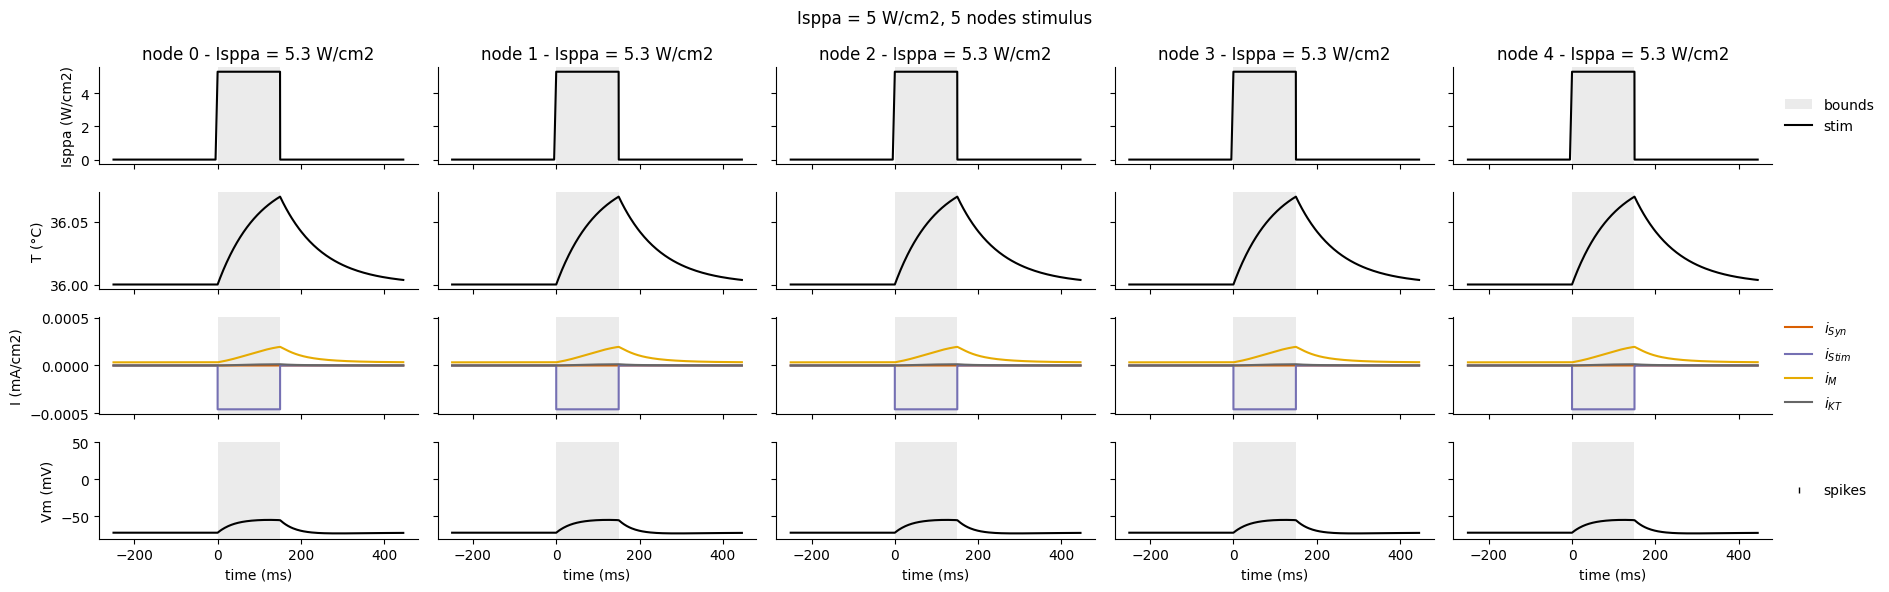

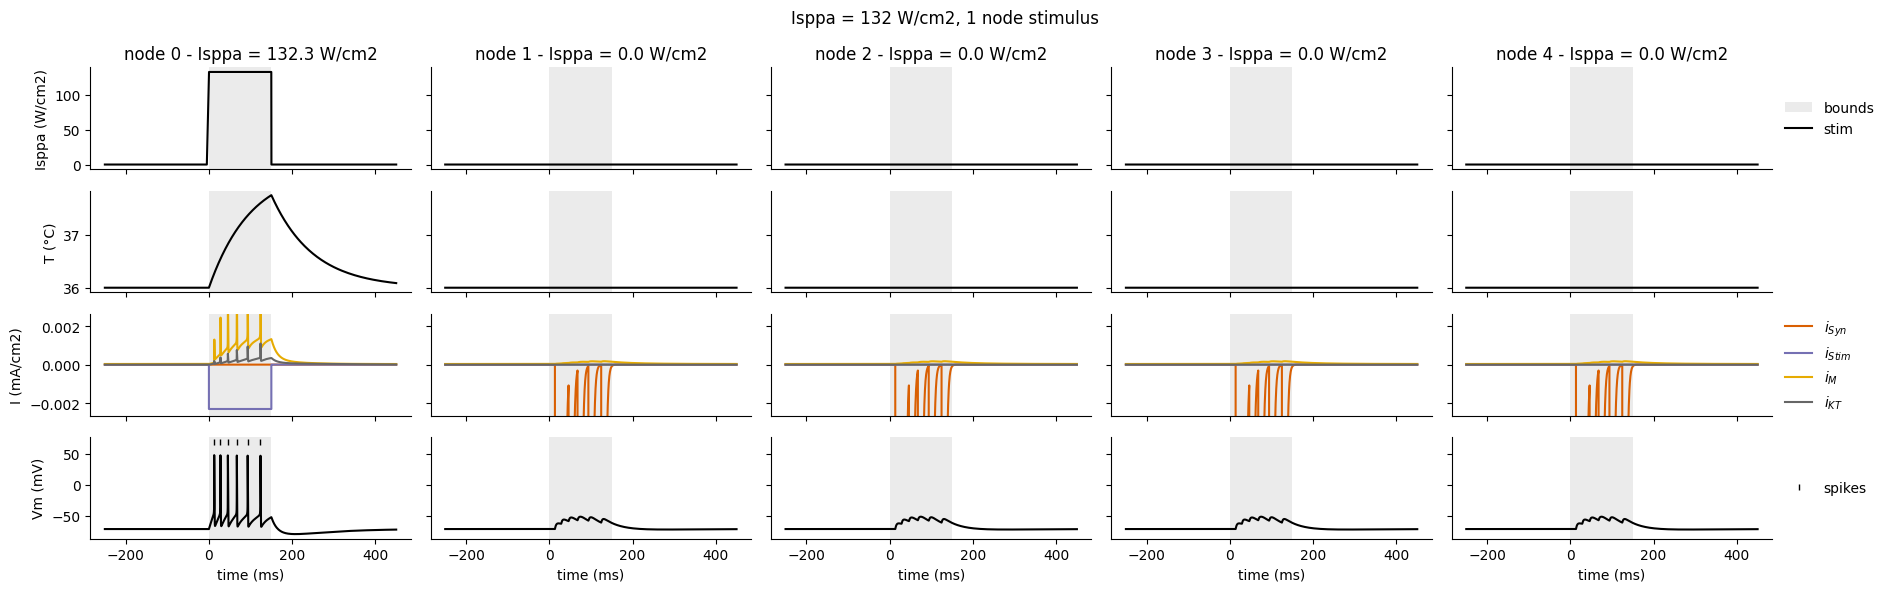

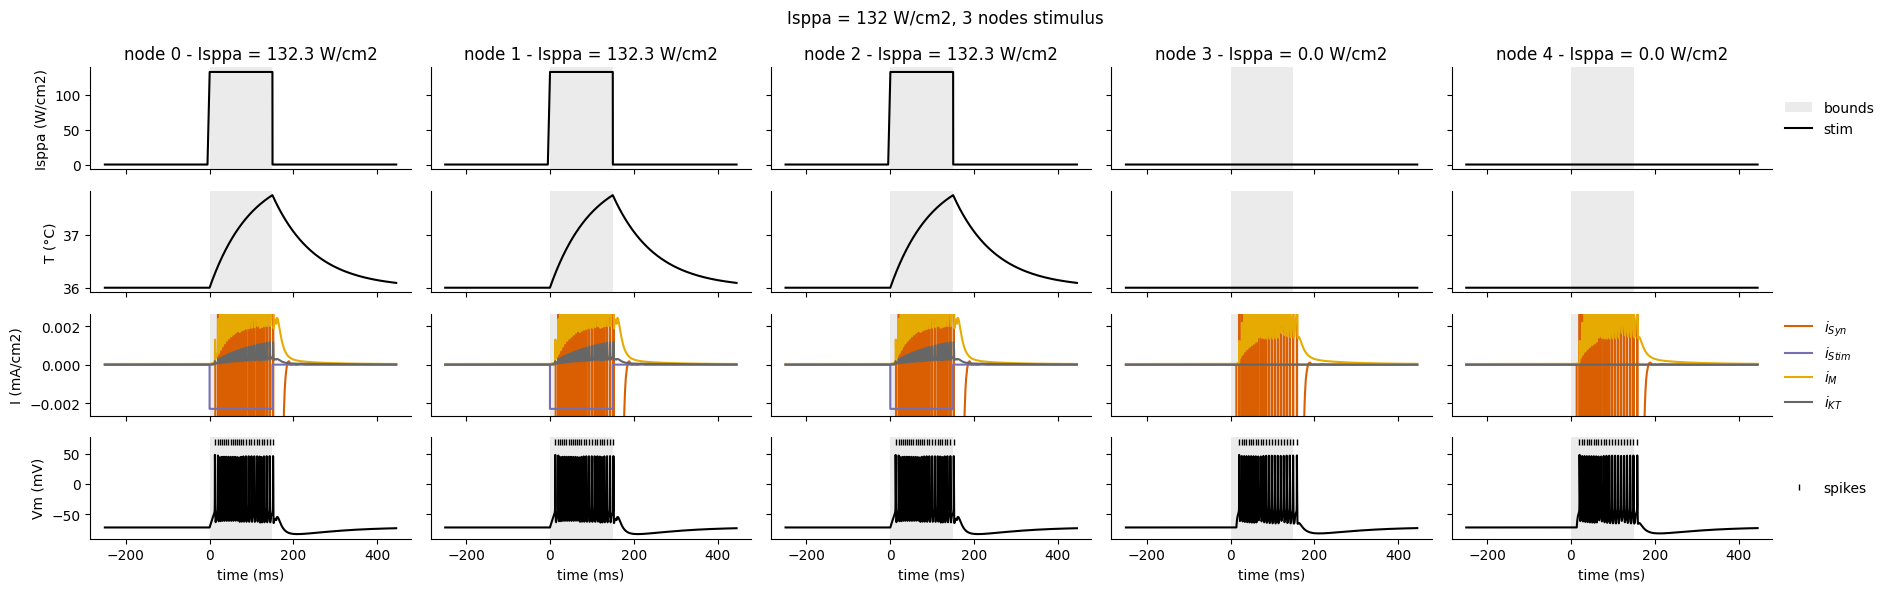

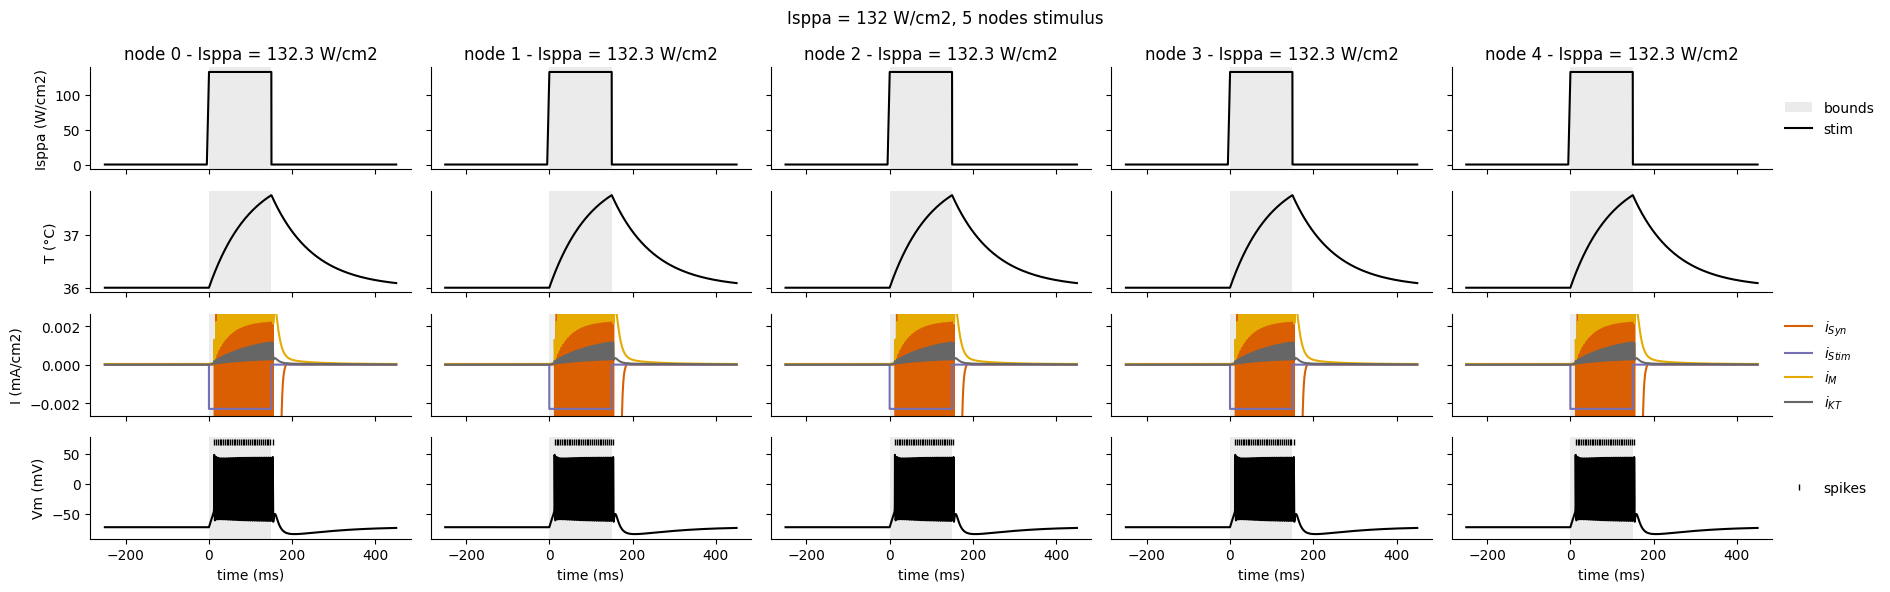

In [23]:
# Define synaptic weight stimulus sensitivity parameter
model5.set_synaptic_weight(50e-6)
model5.set_mech_param(
    a=2e-4, 
    b=0.5
)

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

# Plot E/I imbalance across Isppa range
model5.plot_EI_imbalance(Imax, ax=axes[0], legend=True, xscale='sqrt')

# Plot comparative spike count across Isppa range
metric = model5.run_comparative_sweep(Isppa_range_dense, 'nspikes', stimdists=stimdists)
model5.plot_sweep_results(metric, ax=axes[1], legend=True, marker=None, xscale='sqrt')

# Adjust figure title and layout
fig.suptitle(f'w = {model5.get_synaptic_weight() * 1e6:.0f}uS/cm2, a = {model5.a:.2e}, b = {model5.b}', fontsize=12)
fig.tight_layout()

# Find just sub-threshold Isppa values for each configuration
Ithrs = np.sort(model5.find_threshold(metric, value=10).unique())

# Run comparative simulations and plot results with each sub-threshold Isppa values
for Isppa in Ithrs:
    fig.axes[1].axvline(Isppa, color='k', linestyle='--')
    for kind, xvec in stimdists.items():
        model5.set_stim(Isppa * xvec)
        data = model5.simulate()
        model5.plot_results(
            data,
            exclude=['conductances', 'iNa', 'iKd', 'iLeak'],
            clip_currents=True, 
            # curr_polarity='rectified',
            title=f'Isppa = {Isppa:.0f} W/cm2, {kind} stimulus')

## Log completion

In [11]:
logger.info(f'notebook completed in {timedelta(seconds=time.perf_counter() - t0)}')

 03/12/2023 19:28:40: notebook completed in 0:05:14.231183
